 ### lets import necessary things here

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#to define the models
import torch
import torch.nn as nn

In [ ]:
# get GPU details if available

def get_gpu_details():
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_cached(0)
    a = torch.cuda.memory_allocated(0)
    print(torch.cuda.get_device_name())
    print(f'Total GPU Memory {t} B , Cached GPU Memory {c} B, Allocated GPU Memory {a} B')



if torch.cuda.is_available():
    device='cuda:0'
else:
    device='cpu'
print(f'Current Device: {device}')
if device=='cuda:0':
    torch.cuda.empty_cache()
    get_gpu_details()

Current Device: cuda:0
Tesla T4
Total GPU Memory 15835660288 B , Cached GPU Memory 0 B, Allocated GPU Memory 0 B


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = self.values(values)  # (N, value_len, embed_size)
        keys = self.keys(keys)  # (N, key_len, embed_size)
        queries = self.queries(query)  # (N, query_len, embed_size)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out



In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out


In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size,
        num_layers,
        forward_expansion,
        heads,
        dropout,
        device,
        max_length=100,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out




### Lets implements the Transformer we just created

### load the dataset

In [ ]:
!pip install -U torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [ ]:
# import pandas as pd

# # Load the CSV file
# df = pd.read_csv('/content/drive/MyDrive/chatbot/Transormer_implementation_Scratch/cleaned-15814.csv')
# # Drop the unnamed column
# df = df.drop(columns=['Unnamed: 2'])


# # Check the first few rows of the DataFrame
# print(df.head())


this be commented because it was for preparing dataset

In [ ]:
# import pandas as pd
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# # Download necessary resources for NLTK
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# # Preprocessing function
# def preprocess_sentence(sentence):
#     # Lowercase and strip
#     sentence = sentence.lower().strip()
#     # Creating a space between a word and the punctuation following it
#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
#     sentence = re.sub(r'[" "]+', " ", sentence)
#     # Removing contractions
#     sentence = re.sub(r"i'm", "i am", sentence)
#     sentence = re.sub(r"he's", "he is", sentence)
#     sentence = re.sub(r"she's", "she is", sentence)
#     sentence = re.sub(r"it's", "it is", sentence)
#     sentence = re.sub(r"that's", "that is", sentence)
#     sentence = re.sub(r"what's", "that is", sentence)
#     sentence = re.sub(r"where's", "where is", sentence)
#     sentence = re.sub(r"how's", "how is", sentence)
#     sentence = re.sub(r"\'ll", " will", sentence)
#     sentence = re.sub(r"\'ve", " have", sentence)
#     sentence = re.sub(r"\'re", " are", sentence)
#     sentence = re.sub(r"\'d", " would", sentence)
#     sentence = re.sub(r"\'re", " are", sentence)
#     sentence = re.sub(r"won't", "will not", sentence)
#     sentence = re.sub(r"can't", "cannot", sentence)
#     sentence = re.sub(r"n't", " not", sentence)
#     sentence = re.sub(r"n'", "ng", sentence)
#     sentence = re.sub(r"'bout", "about", sentence)
#     # Replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
#     sentence = re.sub(r"[^a-zA-Z?.!,0-9 %]+", " ", sentence)
#     sentence = sentence.strip()
#     return sentence

# # # Stop words removal and lemmatization function
# # def preprocess_text(text):
# #     # Tokenize the text
# #     tokens = nltk.word_tokenize(text)
# #     # Remove stop words
# #     #stop_words = set(stopwords.words("english"))
# #     #filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
# #     # Lemmatize the tokens
# #     lemmatizer = WordNetLemmatizer()
# #     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.lower()]
# #     return " ".join(lemmatized_tokens)

# # Apply preprocessing to each question and answer
# df['Question'] = df['Question'].apply(preprocess_sentence)
# # df['Question'] = df['Question'].apply(preprocess_text)
# df['Answer'] = df['Answer'].apply(preprocess_sentence)
# # df['Answer'] = df['Answer'].apply(preprocess_text)

# # Save the preprocessed data back to the DataFrame
# df.to_csv("/content/drive/MyDrive/chatbot/Transormer_implementation_Scratch/cleaneddata3.csv", index=False)


###lets start(approach 1)

In [ ]:
import pandas as pd
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/newTransformerNlp/Finalcleaneddata3.csv')
# Drop the unnamed column
#df = df.drop(columns=['Unnamed: 2'])


# Check the first few rows of the DataFrame
print(df.head())

# df = df.sample(frac=1).reset_index(drop=True)
# print(df.head())


                                            Question  \
0  what distinguishes the statue of king bhupatin...   
1  where can tourists closely inspect king bhupat...   
2  in which direction does king bhupatindra malla...   
3  describe the posture of king bhupatindra malla...   
4  what adornments surround king bhupatindra mall...   

                                              Answer  
0  one notable aspect of the statue is its except...  
1  tourists can meticulously examine the statue s...  
2  positioned opposite the golden gate , the stat...  
3  king bhupatindra malla is depicted with crosse...  
4  the statue is encircled by snake , lotus , and...  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.utils.data import Dataset, DataLoader

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization function
tokenizer = get_tokenizer("basic_english")

# Build vocabulary
def yield_tokens(data_iter):
    for _, row in data_iter:
        yield from tokenizer(row["Question"])
        yield from tokenizer(row["Answer"])

# Create a dictionary of tokens
tokens_dict = {'<sos>': 0, '<eos>': 1, '<pad>': 2, '<unk>': 3}
for token in yield_tokens(train_df.iterrows()):
    tokens_dict[token] = tokens_dict.get(token, 0) + 1

# Manually add <sos> and <eos> tokens to the dictionary
tokens_dict['<sos>'] = len(tokens_dict)
tokens_dict['<eos>'] = len(tokens_dict)

# Create a new Vocab object
vocab = Vocab(tokens_dict)

from torch.nn.utils.rnn import pad_sequence

import torch

class QADataset(Dataset):
    def __init__(self, dataframe, tokenizer, vocab, max_seq_length):
        self.questions = ["<sos> " + " ".join(tokenizer(row["Question"])) + " <eos>" for _, row in dataframe.iterrows()]
        self.answers = ["<sos> " + " ".join(tokenizer(row["Answer"])) + " <eos>" for _, row in dataframe.iterrows()]
        self.vocab = vocab
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = [self.vocab[token] for token in self.questions[idx].split()]
        answer = [self.vocab[token] for token in self.answers[idx].split()]

        # Pad or truncate sequences to max_seq_length
        question = torch.tensor(question[:self.max_seq_length] + [self.vocab['<pad>']] * (self.max_seq_length - len(question)), dtype=torch.long)
        answer = torch.tensor(answer[:self.max_seq_length] + [self.vocab['<pad>']] * (self.max_seq_length - len(answer)), dtype=torch.long)

        return question, answer






# Create datasets and data loaders
# Define max sequence length
max_seq_length = 100

batch_size = 64
train_dataset = QADataset(train_df, tokenizer, vocab,max_seq_length)
val_dataset = QADataset(val_df, tokenizer, vocab, max_seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
train_loader


In [ ]:
# Access a single pair from train_dataset
index_to_print = 0  # Index of the pair you want to print
question, answer = train_dataset[index_to_print]

# Convert tensor to list of token indices
question_indices = question.tolist()
answer_indices = answer.tolist()

# Convert token indices to actual tokens using the vocabulary
question_tokens = [vocab.itos[index] for index in question_indices if index != vocab['<pad>']]
answer_tokens = [vocab.itos[index] for index in answer_indices if index != vocab['<pad>']]

# Convert tokens to strings
question_str = ' '.join(question_tokens)
answer_str = ' '.join(answer_tokens)

# Print the question and answer
print("Question:", question_str)
print("Answer:", answer_str)

Question: <sos> after the earthquake , what measures have been taken to assess the structural damage of nyatapola temple ? <eos>
Answer: <sos> structural assessment including visual inspection , structural analysis and stability monitoring is carried out to assess the damage to nyatapola temple after the earthquake . <eos>


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
num_layers = 4
forward_expansion = 4
heads =4
dropout = 0.083
learning_rate = 0.01
num_epochs = 50

In [ ]:
model = Transformer(
    src_vocab_size=len(vocab),
    trg_vocab_size=len(vocab),
    src_pad_idx=vocab["<pad>"],
    trg_pad_idx=vocab["<pad>"],
    embed_size=embed_size,
    num_layers=num_layers,
    forward_expansion=forward_expansion,
    heads=heads,
    dropout=dropout,
    device=device
).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.95)



In [ ]:
from IPython.display import Image

Image('/content/transformer_model.png')


In [ ]:
!pip install torchsummary
!pip install torchinfo


In [ ]:
from torchinfo import summary

# Assuming your model is named 'model' and it's already defined
# Define input shapes for both question and answer
input_shapes = [(128, 100), (128, 100)]

# Print the model summary
summary(model, input_shapes=input_shapes)


Layer (type:depth-idx)                        Param #
Transformer                                   --
├─Encoder: 1-1                                --
│    └─Embedding: 2-1                         1,789,952
│    └─Embedding: 2-2                         25,600
│    └─ModuleList: 2-3                        --
│    │    └─TransformerBlock: 3-1             789,760
│    │    └─TransformerBlock: 3-2             789,760
│    │    └─TransformerBlock: 3-3             789,760
│    │    └─TransformerBlock: 3-4             789,760
│    └─Dropout: 2-4                           --
├─Decoder: 1-2                                --
│    └─Embedding: 2-5                         1,789,952
│    └─Embedding: 2-6                         25,600
│    └─ModuleList: 2-7                        --
│    │    └─DecoderBlock: 3-5                 1,053,440
│    │    └─DecoderBlock: 3-6                 1,053,440
│    │    └─DecoderBlock: 3-7                 1,053,440
│    │    └─DecoderBlock: 3-8                 1,05

learning curve ko lagi

In [ ]:
import torch

# Define functions to calculate loss and accuracy
def calculate_loss_and_accuracy(output, target, criterion, pad_idx):
    # Flatten the output and target tensors
    output_flat = output.view(-1, output.shape[-1])
    target_flat = target.reshape(-1)  # Use reshape instead of view

    # Ignore padding tokens in the target sequence
    non_pad_mask = target_flat != pad_idx
    loss = criterion(output_flat, target_flat)

    # Calculate accuracy
    _, predicted = torch.max(output_flat, dim=1)
    correct = (predicted == target_flat) & non_pad_mask
    accuracy = correct.sum().item() / non_pad_mask.sum().item()

    return loss, accuracy

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0

    for batch_idx, (question, answer) in enumerate(train_loader):
        question = question.to(device)
        answer = answer.to(device)

        optimizer.zero_grad()

        # Remove <eos> token from the target sequence
        target = answer[:, 1:]

        output = model(question, answer[:, :-1])
            # Print output and target tensors for visual comparison
        print("Output tensor:", output.shape)
        print("Target tensor:", target.shape)

        loss, accuracy = calculate_loss_and_accuracy(output, target, criterion, vocab["<pad>"])

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_accuracy += accuracy

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0

    with torch.no_grad():
        for batch_idx, (question, answer) in enumerate(val_loader):
            question = question.to(device)
            answer = answer.to(device)

            # Remove <eos> token from the target sequence
            target = answer[:, 1:]

            output = model(question, answer[:, :-1])

            loss, accuracy = calculate_loss_and_accuracy(output, target, criterion, vocab["<pad>"])

            total_val_loss += loss.item()
            total_val_accuracy += accuracy

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")


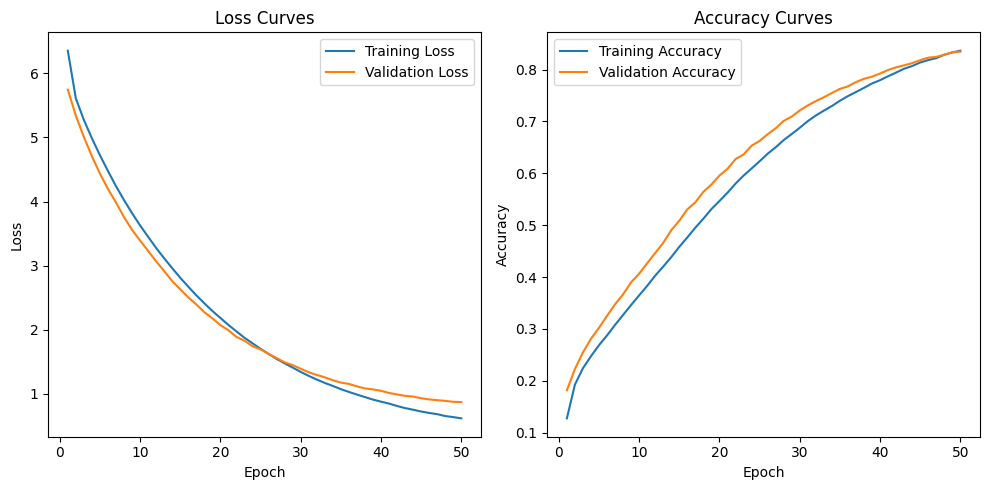

In [ ]:
# Plotting the training and validation curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Plot Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()